In [ ]:
import requests
import re
from bs4 import BeautifulSoup
import pandas as pdpp
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [ ]:
url1='https://www.flipkart.com/search?q=tv&otracker=search&otracker1=search&marketplace=FLIPKART&as-show=on&as=off&page='

In [ ]:
request_header = {'Content-Type': 'text/html; charset=UTF-8','User-Agent': 'Chrome/101.0.0.0 (Windows NT 10.0; Win64; x64; rv:109.0) Gecko/20100101 Firefox/119.0','Accept-Encoding': 'gzip, deflate, br'}
page = requests.get(url1,headers=request_header)

In [ ]:
page

In [ ]:
soup = BeautifulSoup(page.text)

In [ ]:
warranty = soup.find('ul', class_='G4BRas')
warranty.text

In [ ]:
# Lists to store data from multiple pages
Brand = []
Model = []
DisplaySize = []
Resolution = []
Rating = []
Original_price=[]
Sale_price=[]
Operating_system=[]
Warranty=[]

# Loop through the page numbers (for example, from 1 to 50)
for i in range(1,30):
    url = url1 + str(i)  # Construct the URL for each page
   
    
    # Request the page content
    
    page = requests.get(url, headers=request_header)
    soup = BeautifulSoup(page.content, 'html.parser')
    
    # Find all containers on the page
    container = soup.find_all("div", class_="tUxRFH")
    for i in container:
        # Extracting the brand and model (usually in the title or name section)
        title = i.find("div", class_="KzDlHZ") 
        text = title.text if title else ""
        
        # Extract brand (assumes brand is the first word in title)
        brand = re.findall("^\w+", text)
        Brand.append(brand[0] if brand else np.nan)


        # Extract model (usually after the brand name in the title)
        model = re.findall(r"([A-Za-z0-9\s\-]+)(?=\s*\d{1,2}\s*(inch|cm))", text)
        model=[m[0].strip() for m in model]
        Model.append(model[0] if model else np.nan)
    

        # Extract display size (look for pattern, e.g., 43 inch)
        display_size = re.findall("(\d+\.\d+|\d+) inch", text)
        DisplaySize.append(display_size[0] if display_size else np.nan)

        # Extract resolution (e.g., Full HD, Ultra HD, etc.)
        resolution = re.findall(r"(LED|QLED|Smart|Android|Linux|WebOS|Full HD|Ultra HD|HD Ready)[^\d]*", text)
        Resolution.append(resolution[0] if resolution else np.nan)

        # Extract rating
        rating = i.find("div", class_="XQDdHH")  # Flipkart's class for ratings
        Rating.append(rating.text if rating else np.nan)

        original_price=i.find('div',class_='yRaY8j ZYYwLA')
        Original_price.append(original_price.text if original_price else np.nan)

        sale_price=i.find('div',class_='Nx9bqj _4b5DiR')
        Sale_price.append(sale_price.text if sale_price else np.nan)

        operating_system=i.find('li',class_='J+igdf')
        if operating_system:
            os_text = operating_system.text.split(": ", 1)[-1]
        else:
            os_text = np.nan

        Operating_system.append(os_text)

        warranty = i.find('ul', class_='G4BRas')
        warranty_text = np.nan

        if warranty:
          cleaned_text = re.sub(r'^\d+\s*', '', warranty.text).strip()
          match = re.search(r'\b(\d+)\s*Year[s]?\b', cleaned_text, re.IGNORECASE)
          if match:
               warranty_text = f"{match.group(1)} Year Warranty"
        Warranty.append(warranty_text)
        
     
print(Brand)
print(Model)
print(DisplaySize)
print(Resolution)
print(Rating)
print(Original_price)
print(Sale_price)
print(Operating_system)
print(Warranty)

In [348]:
d = {"Brand":Brand,"Model":Model,"DisplaySize":DisplaySize,"Resolution":Resolution,"Rating":Rating,"Original_Price":Original_price,'Sale_Price':Sale_price,"Operating_system":Operating_system,"Warranty":Warranty}

In [352]:
df = pd.DataFrame(d)

In [354]:
df['Operating_system'] = df['Operating_system'].replace('HD Ready 1366 x 768 Pixels', np.nan)
# Identify values in Operating_system column with less than 4 occurrences
low_freq_values = df['Operating_system'].value_counts()[df['Operating_system'].value_counts() < 20].index

# Replace those low-frequency values with NaN
df['Operating_system'] = df['Operating_system'].replace(low_freq_values, np.nan)

In [356]:
# Replace those low-frequency values with NaN
df['Operating_system'].value_counts()

Operating_system
Android                              234
Google TV                            177
WebOS                                 39
Tizen                                 34
HD Ready 1366 x 768 pixels Pixels     29
Name: count, dtype: int64

In [358]:
result = []
for text in df['Warranty']:
    # Check if the text is a string and starts with four digits
    if isinstance(text, str) and re.match(r'^\d{4}', text):
        # Remove the first four characters
        result.append(text[4:])
    else:
        # If the text does not start with four digits, keep it as is
        result.append(text)

# Assign the result back to a new column in the DataFrame
df['Warranty_Modified'] = result

In [362]:
df = df.drop('Warranty',axis=1)

In [364]:
df=df.rename(columns={'Warraty_Modified':'Warranty'})

In [366]:
df['Model'] = df['Model'].apply(lambda x: np.nan if isinstance(x, str) and len(x) == 1 else x)

In [369]:
rows=df.shape[0]
print(rows)

696


In [371]:
columns=df.shape[1]
print(columns)

9


In [373]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 696 entries, 0 to 695
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Brand              696 non-null    object
 1   Model              661 non-null    object
 2   DisplaySize        689 non-null    object
 3   Resolution         696 non-null    object
 4   Rating             445 non-null    object
 5   Original_Price     694 non-null    object
 6   Sale_Price         696 non-null    object
 7   Operating_system   513 non-null    object
 8   Warranty_Modified  660 non-null    object
dtypes: object(9)
memory usage: 49.1+ KB


In [375]:
df.isnull().sum()

Brand                  0
Model                 35
DisplaySize            7
Resolution             0
Rating               251
Original_Price         2
Sale_Price             0
Operating_system     183
Warranty_Modified     36
dtype: int64

In [377]:
df['Original_Price'] = df['Original_Price'].apply(lambda x: x.replace('₹', '') if isinstance(x, str) else x)

In [379]:
df['Sale_Price'] = df['Sale_Price'].apply(lambda x: x.replace('₹', '') if isinstance(x, str) else x)

In [381]:
df['DisplaySize'] = df['DisplaySize'].replace('NaN',np.nan)
df['DisplaySize'] = df['DisplaySize'].fillna(0).astype(float)

In [383]:
df['Operating_system'].value_counts()

Operating_system
Android                              234
Google TV                            177
WebOS                                 39
Tizen                                 34
HD Ready 1366 x 768 pixels Pixels     29
Name: count, dtype: int64

In [385]:
df['Operating_system'] = df['Operating_system'].replace('HD Ready 1366 x 768 Pixels', np.nan)
df['Operating_system'] = df['Operating_system'].replace('HD Ready 1366 x 768 pixels Pixels','Tizen')
low_freq_values = df['Operating_system'].value_counts()[df['Operating_system'].value_counts() < 23].index

df['Operating_system'] = df['Operating_system'].replace(low_freq_values, np.nan)

In [387]:
df['Rating'].isnull().sum()/len(df)*100

36.06321839080459

In [389]:
df['Rating']=df['Rating'].astype('float')

In [391]:
df['Rating']=df['Rating'].fillna(df['Rating'].mean())

In [393]:
df['Original_Price'] = df['Original_Price'].apply(lambda x: x.replace(',', '') if isinstance(x, str) else x)
df['Sale_Price'] = df['Sale_Price'].apply(lambda x: x.replace(',', '') if isinstance(x, str) else x)
df['Original_Price']=df['Original_Price'].astype('float')
df['Sale_Price']=df['Sale_Price'].astype('float')

In [395]:
df['Warranty_Modified']=df['Warranty_Modified'].fillna(df['Warranty_Modified'].mode())

In [406]:
df=df.dropna(ignore_index=True)


In [408]:
df.duplicated().sum()

169

In [401]:
df['Original_Price'].mean()

52153.38888888889

In [403]:
df.head(20)

,Brand,Model,DisplaySize,Resolution,Rating,Original_Price,Sale_Price,Operating_system,Warranty_Modified
0,IAIR,IAIR 10,43.0,HD Ready,4.176854,43490.0,24086.0,Android,5 Year Warranty
1,SAMSUNG,SAMSUNG 8,0.0,HD Ready,4.300000,18900.0,15240.0,Tizen,1 Year Warranty
2,Mi,Mi by Xiaomi A Series 8,32.0,HD Ready,4.300000,24999.0,12990.0,Google TV,1 Year Warranty
3,LG,LG 32LQBPTA 8,32.0,HD Ready,4.300000,19990.0,13990.0,WebOS,1 Year Warranty
4,MOTOROLA,MOTOROLA EnvisionX 10,43.0,QLED,4.200000,51999.0,20999.0,Google TV,1 Year Warranty
5,IAIR,IAIR 6,24.0,HD Ready,4.176854,15999.0,6027.0,Tizen,5 Year Warranty
6,XElectron,XElectron 10,43.0,Ultra HD,4.100000,34999.0,19950.0,Android,1 Year Warranty
7,IAIR,IAIR 10,43.0,HD Ready,4.176854,41990.0,19933.0,Android,5 Year Warranty
8,IAIR,IAIR 8,32.0,HD Ready,4.176854,25499.0,11624.0,Android,5 Year Warranty
9,TCL,TCL V6B 13,55.0,Ultra HD,4.100000,77990.0,29990.0,Google TV,2 Year Warranty


In [ ]:
df.plot(kind='box')

In [1]:
df.shape

NameError: name 'df' is not defined

# univariate analysis

In [100]:
df.columns

Index(['Brand', 'Model', 'DisplaySize', 'Resolution', 'Rating',
       'Original_Price', 'Sale_Price', 'Operating_system',
       'Warranty_Modified'],
      dtype='object')

In [108]:
df["Brand"].value_counts()

Brand
IAIR           139
SAMSUNG         32
XElectron       29
Hisense         19
Acer            18
LG              16
TOSHIBA         14
TCL             13
Sansui          13
MOTOROLA        11
Thomson         11
Haier           11
Mi              10
Daiwa            8
Infinix          8
Blaupunkt        8
Lloyd            7
Coocaa           7
KODAK            7
SONY             6
Panasonic        6
iFFALCON         6
realme           6
Vu               5
CANDY            5
Foxsky           5
Admiral          4
INVANTER         4
acerpure         4
SENS             4
IMPEX            4
BPL              3
InnoQ            3
Reliance         3
ONIDA            3
NU               2
Samtonic         2
LIMEBERRY        2
Dyanora          1
OnePlus          1
REDMI            1
LEEMA            1
VONE             1
MarQ             1
T                1
REALMERCURY      1
INAYA            1
SKYTRON          1
Name: count, dtype: int64

# univariate analaysis on brand

In [410]:
df["Brand"].value_counts()

Brand
IAIR           139
SAMSUNG         32
XElectron       29
Hisense         19
Acer            18
LG              16
TOSHIBA         14
TCL             13
Sansui          13
MOTOROLA        11
Thomson         11
Haier           11
Mi              10
Daiwa            8
Infinix          8
Blaupunkt        8
Lloyd            7
Coocaa           7
KODAK            7
SONY             6
Panasonic        6
iFFALCON         6
realme           6
Vu               5
CANDY            5
Foxsky           5
Admiral          4
INVANTER         4
acerpure         4
SENS             4
IMPEX            4
BPL              3
InnoQ            3
Reliance         3
ONIDA            3
NU               2
Samtonic         2
LIMEBERRY        2
Dyanora          1
OnePlus          1
REDMI            1
LEEMA            1
VONE             1
MarQ             1
T                1
REALMERCURY      1
INAYA            1
SKYTRON          1
Name: count, dtype: int64

In [412]:
df["Brand"].unique()

array(['IAIR', 'SAMSUNG', 'Mi', 'LG', 'MOTOROLA', 'XElectron', 'TCL',
       'iFFALCON', 'InnoQ', 'Infinix', 'Thomson', 'Sansui', 'Acer',
       'Haier', 'Foxsky', 'KODAK', 'realme', 'TOSHIBA', 'Blaupunkt', 'Vu',
       'SONY', 'SENS', 'ONIDA', 'Panasonic', 'Hisense', 'Daiwa',
       'acerpure', 'Coocaa', 'IMPEX', 'Reliance', 'Admiral', 'MarQ',
       'REDMI', 'CANDY', 'NU', 'Dyanora', 'OnePlus', 'BPL', 'Lloyd',
       'LEEMA', 'Samtonic', 'VONE', 'INVANTER', 'LIMEBERRY', 'T',
       'REALMERCURY', 'INAYA', 'SKYTRON'], dtype=object)

In [414]:
df["Brand"].nunique()

48

<Axes: xlabel='Brand'>

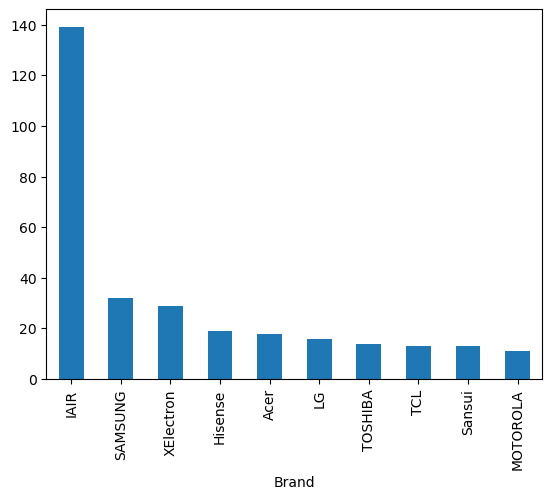

In [120]:
df["Brand"].value_counts().nlargest(10).plot(kind="bar")

<Axes: ylabel='count'>

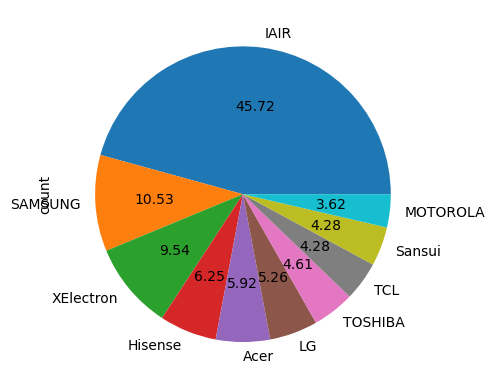

In [122]:
df["Brand"].value_counts().nlargest(10).plot(kind="pie",autopct="%.2f")

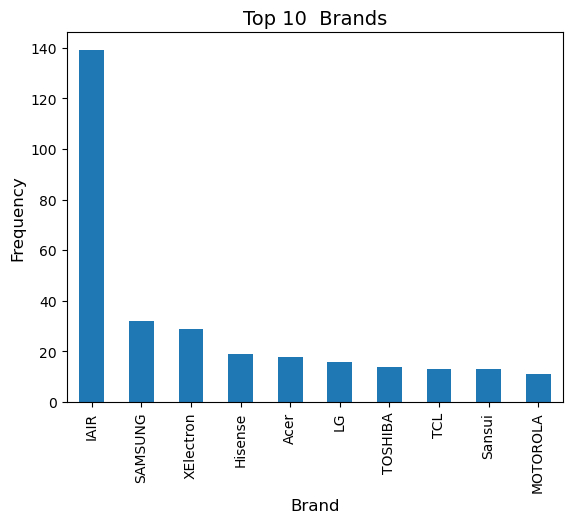

In [124]:
import matplotlib.pyplot as plt

# Plot the top 10 most frequent brands
df["Brand"].value_counts().nlargest(10).plot(kind="bar")

# Add title and axis labels
plt.title("Top 10  Brands", fontsize=14)
plt.xlabel("Brand", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

# Show the plot
plt.show()


<Axes: ylabel='Frequency'>

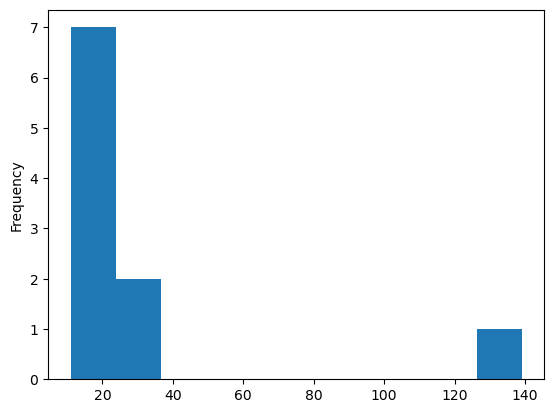

In [126]:
df["Brand"].value_counts().nlargest(10).plot(kind="hist")

In [130]:
# univariate anaysis on model

In [132]:
df["Model"].value_counts()

Model
IAIR 10                                58
IAIR 8                                 52
IAIR 6                                 29
XElectron 10                           29
Sansui 10                               5
                                       ..
Daiwa 8                                 1
TOSHIBA M550LP Series 13                1
SAMSUNG Crystal 4K iSmart Series 16     1
Hisense E68N 13                         1
SKYTRON 10                              1
Name: count, Length: 238, dtype: int64

In [134]:
df["Model"].unique()

array(['IAIR 10', 'SAMSUNG 8', 'Mi by Xiaomi A Series 8', 'LG 32LQBPTA 8',
       'MOTOROLA EnvisionX 10', 'IAIR 6', 'XElectron 10', 'IAIR 8',
       'TCL V6B 13', 'iFFALCON by TCL U64 13', 'InnoQ Spectra 8',
       'TCL C69B 13', 'TCL V6B 10', 'LG 32LMBPTC 8', '10', 'SAMSUNG 10',
       'Infinix 8', 'MOTOROLA EnvisionX 8', 'Thomson Phoenix 10',
       'Mi by Xiaomi X Series 10', 'Sansui 8', 'Acer I PRO Series 10',
       'iFFALCON by TCL U64 10', 'Haier 8', 'MOTOROLA EnvisionX 14',
       'TCL C69B 10', 'Foxsky 8', 'Mi by Xiaomi X Series 12', 'KODAK 13',
       'Thomson FA Series 10', 'realme TechLife CineSonic 14',
       'Mi by Xiaomi A Series 10', 'MOTOROLA 8', 'TCL P71B Pro 13',
       'MOTOROLA EnvisionX 16', 'TOSHIBA C350NP 10',
       'realme TechLife CineSonic Q 10', '13', 'KODAK 8',
       'Acer Advanced I Series 13', 'Foxsky 10', 'Acer Super Series 10',
       'realme TechLife CineSonic Q 14', 'Acer V Series 8', 'TOSHIBA 10',
       'Blaupunkt 12', 'Vu 13', 'SONY 8', 'Vu Glo

In [136]:
df["Model"].nunique()

238

<Axes: xlabel='Model'>

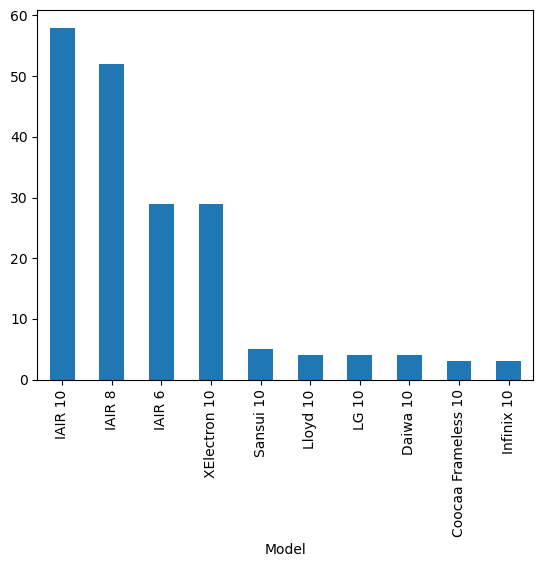

In [138]:
df["Model"].value_counts().nlargest(10).plot(kind="bar")

<Axes: ylabel='count'>

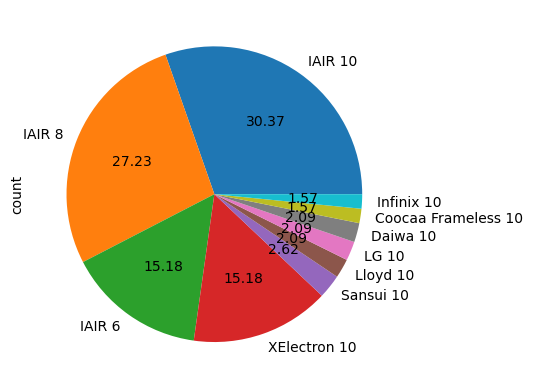

In [139]:
df["Model"].value_counts().nlargest(10).plot(kind="pie",autopct="%.2f")

In [143]:
df.columns

Index(['Brand', 'Model', 'DisplaySize', 'Resolution', 'Rating',
       'Original_Price', 'Sale_Price', 'Operating_system',
       'Warranty_Modified'],
      dtype='object')

In [144]:
print("minimum of displaysize", df["DisplaySize"].min())
print("maximum  of displaysize", df["DisplaySize"].max())
print("mean of displaysize", df["DisplaySize"].mean())
print("standard deviation of displaysize", df["DisplaySize"].std())
print("variance of displaysize", df["DisplaySize"].var())
print("mode of displaysize", df["DisplaySize"].mode())
print("median of displaysize", df["DisplaySize"].median())


minimum of displaysize 0.0
maximum  of displaysize 98.0
mean of displaysize 43.43376068376068
standard deviation of displaysize 13.043736884357342
variance of displaysize 170.1390719083442
mode of displaysize 0    43.0
Name: DisplaySize, dtype: float64
median of displaysize 43.0


In [148]:
# univarite analaysis on displaysize

In [150]:
import pandas as pd

df["DisplaySize"] = pd.to_numeric(df["DisplaySize"], errors='coerce') 


df.dropna(subset=["DisplaySize"], inplace=True)  


print("Mean of DisplaySize:", df["DisplaySize"].mean())
print("Standard deviation of DisplaySize:", df["DisplaySize"].std())
print("Variance of DisplaySize:", df["DisplaySize"].var())
print("Mode of DisplaySize:", df["DisplaySize"].mode())
print("Median of DisplaySize:", df["DisplaySize"].median())
print("Kurtosis of DisplaySize:",df["DisplaySize"].kurtosis())
print("Quantiles of DisplaySize:",df["DisplaySize"].quantile([0.25,0.5,0.75]))



Mean of DisplaySize: 43.43376068376068
Standard deviation of DisplaySize: 13.043736884357342
Variance of DisplaySize: 170.1390719083442
Mode of DisplaySize: 0    43.0
Name: DisplaySize, dtype: float64
Median of DisplaySize: 43.0
Kurtosis of DisplaySize: 1.5881298958555505
Quantiles of DisplaySize: 0.25    32.0
0.50    43.0
0.75    50.0
Name: DisplaySize, dtype: float64


<Axes: ylabel='Density'>

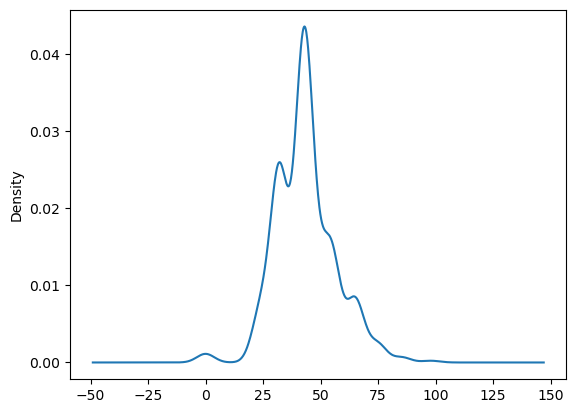

In [152]:
df["DisplaySize"].plot(kind="kde")

<Axes: ylabel='Frequency'>

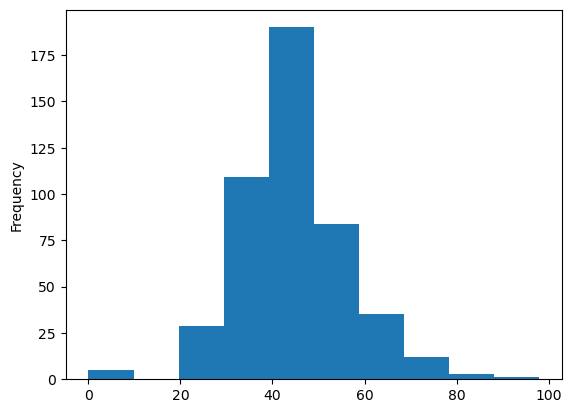

In [153]:
df["DisplaySize"].plot(kind="hist")

<Axes: >

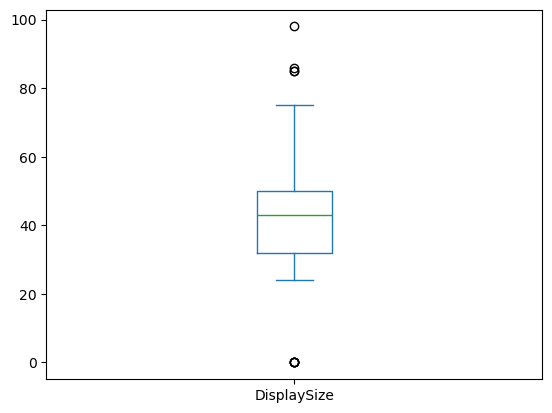

In [155]:
df["DisplaySize"].plot(kind="box")

In [157]:
df.columns

Index(['Brand', 'Model', 'DisplaySize', 'Resolution', 'Rating',
       'Original_Price', 'Sale_Price', 'Operating_system',
       'Warranty_Modified'],
      dtype='object')

# univariate analysis on resolution

In [161]:
print("resolution of value counts",df["Resolution"].value_counts())
print("================================================"*3)
print("unique",df["Resolution"].unique())
print("================================================"*3)
print("n unique",df["Resolution"].nunique())

resolution of value counts Resolution
HD Ready    191
Ultra HD    164
QLED         64
Full HD      43
Smart         4
LED           2
Name: count, dtype: int64
unique ['HD Ready' 'QLED' 'Ultra HD' 'Full HD' 'LED' 'Smart']
n unique 6


<Axes: xlabel='Resolution'>

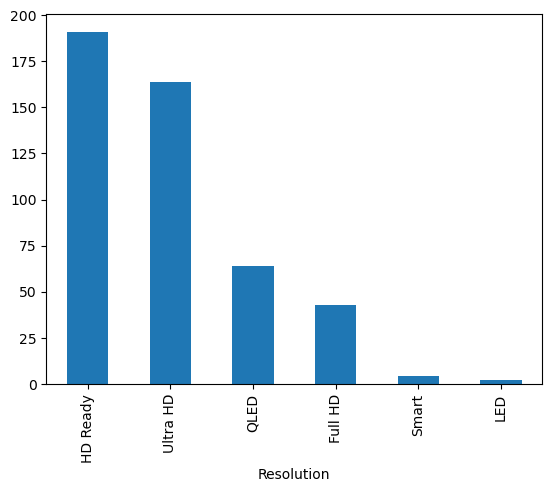

In [163]:
df["Resolution"].value_counts().plot(kind="bar")

<Axes: ylabel='count'>

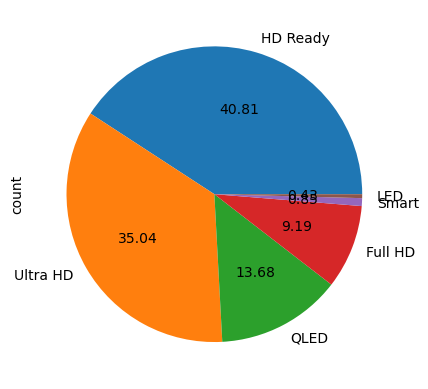

In [164]:
df["Resolution"].value_counts().nlargest(10).plot(kind="pie",autopct="%.2f")

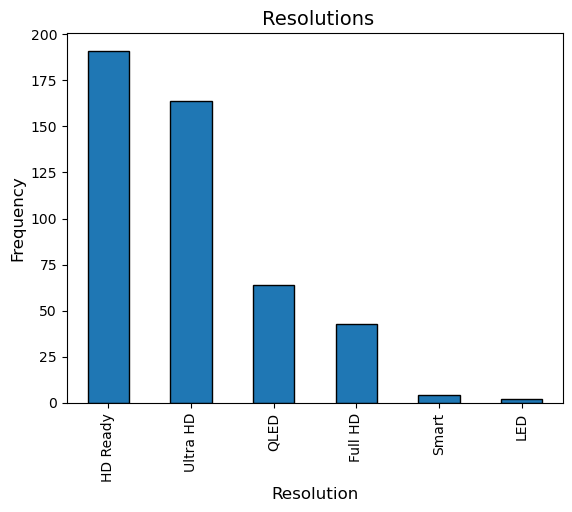

In [167]:
import matplotlib.pyplot as plt

# Plot the top 10 most frequent values of 'Resolution'
df["Resolution"].value_counts().plot(kind="bar", edgecolor='black')

# Add title and axis labels
plt.title(" Resolutions", fontsize=14)
plt.xlabel("Resolution", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

# Show the plot
plt.show()


In [168]:
df.columns

Index(['Brand', 'Model', 'DisplaySize', 'Resolution', 'Rating',
       'Original_Price', 'Sale_Price', 'Operating_system',
       'Warranty_Modified'],
      dtype='object')

# univariate analysis on rating

In [172]:
print("Mean of Rating:", df["Rating"].mean())
print("Standard deviation of Rating:", df["Rating"].std())
print("Variance of Rating:", df["Rating"].var())
print("Mode of Rating:", df["Rating"].mode())
print("Median of Rating:", df["Rating"].median())
print("Kurtosis of Rating:",df["Rating"].kurtosis())
print("Quantiles of Rating:",df["Rating"].quantile([0.25,0.5,0.75]))


Mean of Rating: 4.206909632190531
Standard deviation of Rating: 0.20220460277828745
Variance of Rating: 0.040886701384725006
Mode of Rating: 0    4.176854
Name: Rating, dtype: float64
Median of Rating: 4.176853932584269
Kurtosis of Rating: 29.09614929729751
Quantiles of Rating: 0.25    4.176854
0.50    4.176854
0.75    4.300000
Name: Rating, dtype: float64


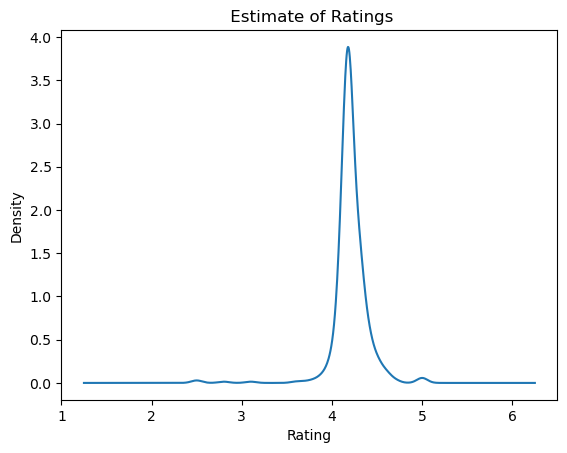

In [418]:
import matplotlib.pyplot as plt

# Plot the KDE
df["Rating"].plot(kind="kde")

# Add title and axis labels
plt.title(' Estimate of Ratings')  # Title for the plot
plt.xlabel('Rating')  # Label for the x-axis
plt.ylabel('Density')  # Label for the y-axis

# Show the plot
plt.show()


In [419]:
df["Rating"].value_counts()

Rating
4.176854    180
4.300000     85
4.100000     60
4.200000     58
4.400000     30
4.000000     15
4.500000     14
4.600000      7
3.900000      5
5.000000      4
4.700000      2
3.800000      2
2.500000      2
3.700000      1
3.600000      1
3.100000      1
2.800000      1
Name: count, dtype: int64

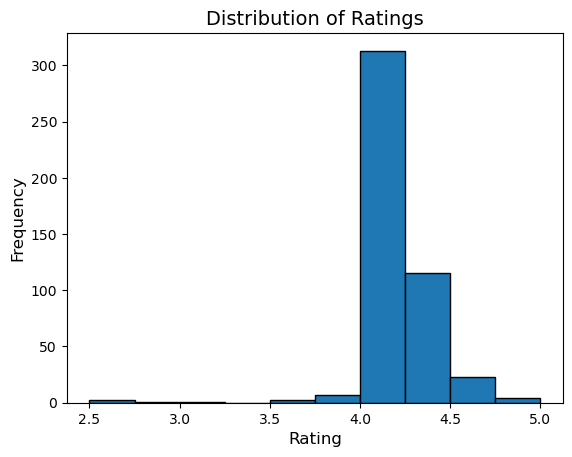

In [422]:
import matplotlib.pyplot as plt

# Plot the histogram for 'Rating'
df["Rating"].plot(kind="hist",edgecolor="Black")

# Add title and axis labels
plt.title("Distribution of Ratings", fontsize=14)
plt.xlabel("Rating", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

# Show the plot
plt.show()


<Axes: >

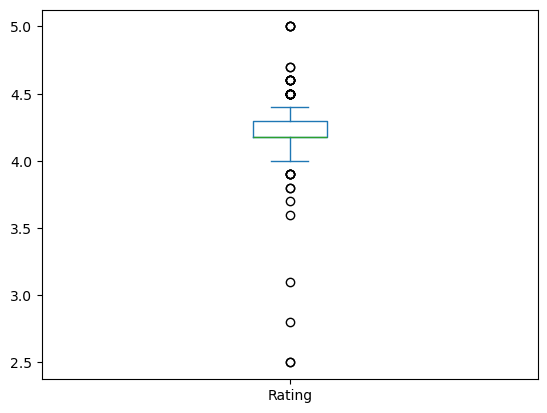

In [425]:
df["Rating"].plot(kind="box")

In [428]:
# univariate analysis on original_price

In [433]:
print("Mean of Original_Price:", df["Original_Price"].mean())
print("Standard deviation of Original_Price:", df["Original_Price"].std())
print("Variance of Original_Price:", df["Original_Price"].var())
print("Mode of Original_Price:", df["Original_Price"].mode())
print("Median of Original_Price:", df["Original_Price"].median())
print("Kurtosis of Original_Price:",df["Original_Price"].kurtosis())
print("Quantiles of Original_Price:",df["Original_Price"].quantile([0.25,0.5,0.75]))


Mean of Original_Price: 52153.38888888889
Standard deviation of Original_Price: 52174.522361876814
Variance of Original_Price: 2722180783.6899834
Mode of Original_Price: 0    25499.0
Name: Original_Price, dtype: float64
Median of Original_Price: 41990.0
Kurtosis of Original_Price: 45.98137619508255
Quantiles of Original_Price: 0.25    25499.0
0.50    41990.0
0.75    59990.0
Name: Original_Price, dtype: float64


<Axes: ylabel='Density'>

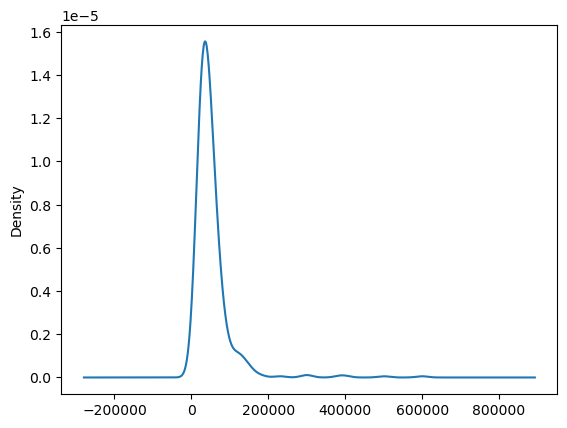

In [435]:
df["Original_Price"].plot(kind="kde")

<Axes: ylabel='Frequency'>

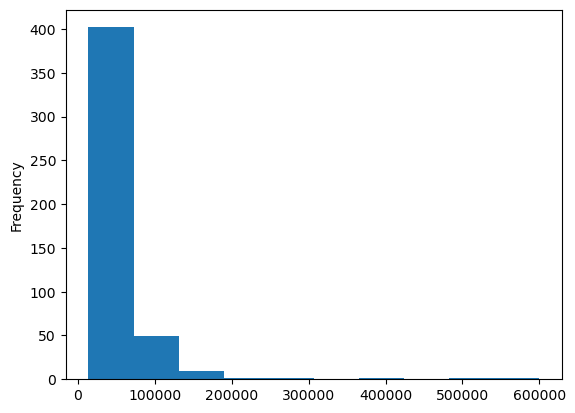

In [436]:
df["Original_Price"].plot(kind="hist")

<Axes: >

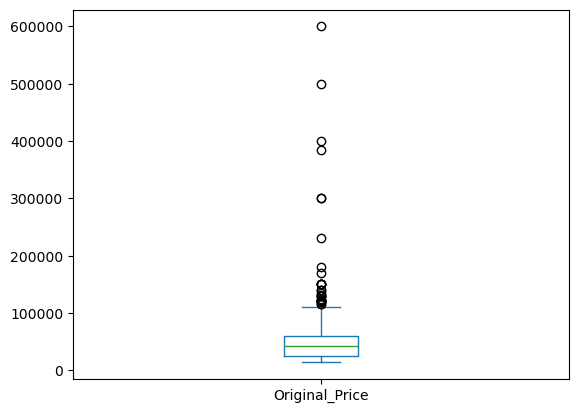

In [438]:
df["Original_Price"].plot(kind="box")

 # univariate analsis on sale_price

In [441]:
print("Mean of Sale_Price:", df["Sale_Price"].mean())
print("Standard deviation of Sale_Price:", df["Sale_Price"].std())
print("Variance of Sale_Price:", df["Sale_Price"].var())
print("Mode of Sale_Price:", df["Sale_Price"].mode())
print("Median of Sale_Price:", df["Sale_Price"].median())
print("Kurtosis of Sale_Price:",df["Sale_Price"].kurtosis())
print("Quantiles of Sale_Price:",df["Sale_Price"].quantile([0.25,0.5,0.75]))


Mean of Sale_Price: 29132.707264957266
Standard deviation of Sale_Price: 31799.03718287405
Variance of Sale_Price: 1011178765.7578063
Mode of Sale_Price: 0     6027.0
1    11624.0
2    19933.0
3    19950.0
4    24086.0
Name: Sale_Price, dtype: float64
Median of Sale_Price: 21399.0
Kurtosis of Sale_Price: 53.257453221494345
Quantiles of Sale_Price: 0.25    13499.75
0.50    21399.00
0.75    33690.00
Name: Sale_Price, dtype: float64


<Axes: ylabel='Density'>

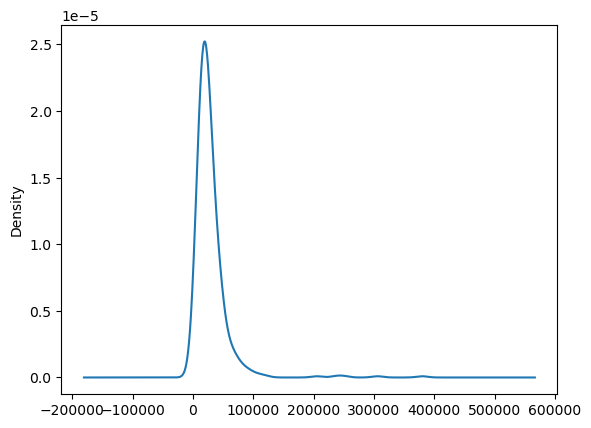

In [443]:
df["Sale_Price"].plot(kind="kde")

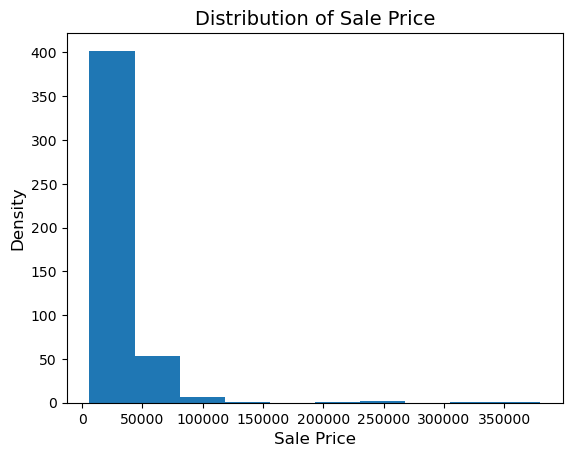

In [445]:
import matplotlib.pyplot as plt

# Plot the KDE for 'Sale_Price'
df["Sale_Price"].plot(kind="hist")

# Add title and axis labels
plt.title("Distribution of Sale Price", fontsize=14)
plt.xlabel("Sale Price", fontsize=12)
plt.ylabel("Density", fontsize=12)

# Show the plot
plt.show()


<Axes: ylabel='Frequency'>

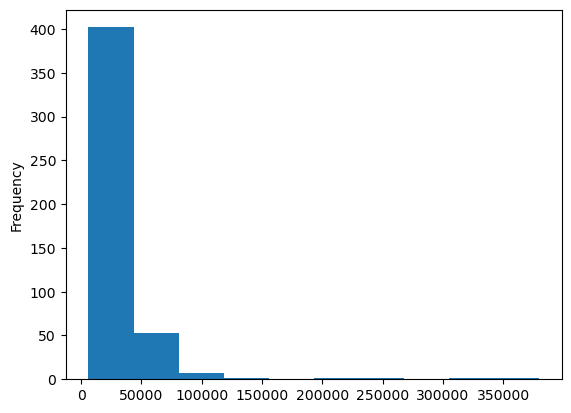

In [446]:
df["Sale_Price"].plot(kind="hist")

<Axes: >

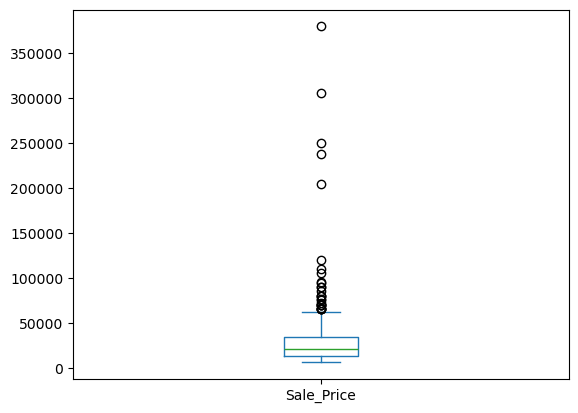

In [448]:
df["Sale_Price"].plot(kind="box")

In [450]:
df.columns

Index(['Brand', 'Model', 'DisplaySize', 'Resolution', 'Rating',
       'Original_Price', 'Sale_Price', 'Operating_system',
       'Warranty_Modified'],
      dtype='object')

# univariate analsysis on operating System

In [453]:
print("Operating_system of value counts",df["Operating_system"].value_counts())
print("================================================"*3)
print("unique",df["Operating_system"].unique())
print("================================================"*3)
print("n unique",df["Operating_system"].nunique())

Operating_system of value counts Operating_system
Android      210
Google TV    164
Tizen         60
WebOS         34
Name: count, dtype: int64
unique ['Android' 'Tizen' 'Google TV' 'WebOS']
n unique 4


<Axes: xlabel='Operating_system'>

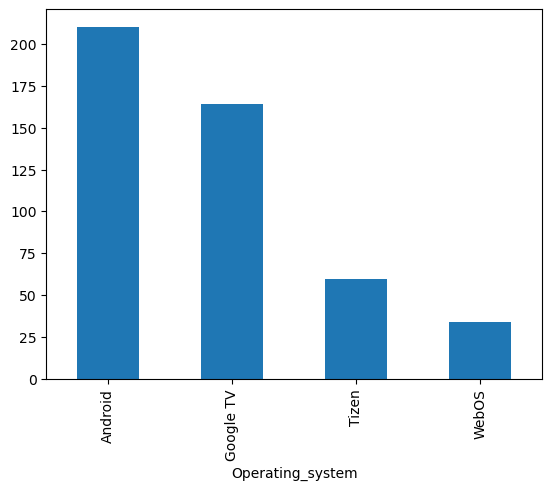

In [454]:
df["Operating_system"].value_counts().nlargest(10).plot(kind="bar")

<Axes: ylabel='count'>

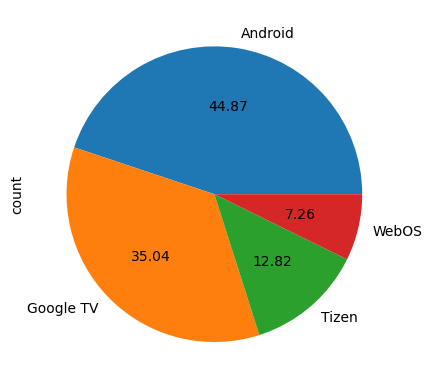

In [458]:
df["Operating_system"].value_counts().nlargest(10).plot(kind="pie",autopct="%.2f")

<Axes: ylabel='Frequency'>

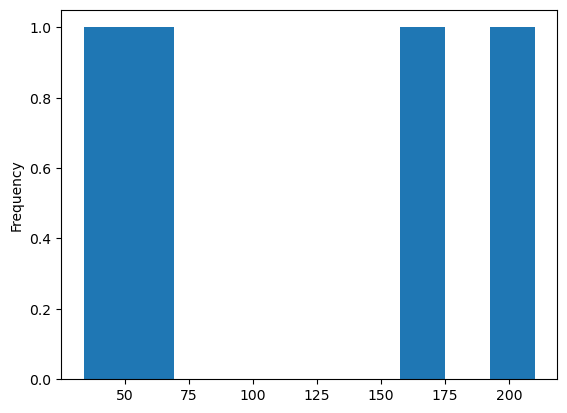

In [459]:
df["Operating_system"].value_counts().plot(kind="hist")

In [467]:
# univariate analaysis on warranty_modified

In [469]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 468 entries, 0 to 467
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Brand              468 non-null    object 
 1   Model              468 non-null    object 
 2   DisplaySize        468 non-null    float64
 3   Resolution         468 non-null    object 
 4   Rating             468 non-null    float64
 5   Original_Price     468 non-null    float64
 6   Sale_Price         468 non-null    float64
 7   Operating_system   468 non-null    object 
 8   Warranty_Modified  468 non-null    object 
dtypes: float64(4), object(5)
memory usage: 33.0+ KB


In [471]:
print("Operating_system of value counts",df["Warranty_Modified"].value_counts())
print("================================================"*3)
print("unique",df["Warranty_Modified"].unique())
print("================================================"*3)
print("n unique",df["Warranty_Modified"].nunique())

Operating_system of value counts Warranty_Modified
1 Year Warranty    252
5 Year Warranty    139
2 Year Warranty     66
3 Year Warranty      7
4 Year Warranty      4
Name: count, dtype: int64
unique ['5 Year Warranty' '1 Year Warranty' '2 Year Warranty' '4 Year Warranty'
 '3 Year Warranty']
n unique 5


<Axes: xlabel='Warranty_Modified'>

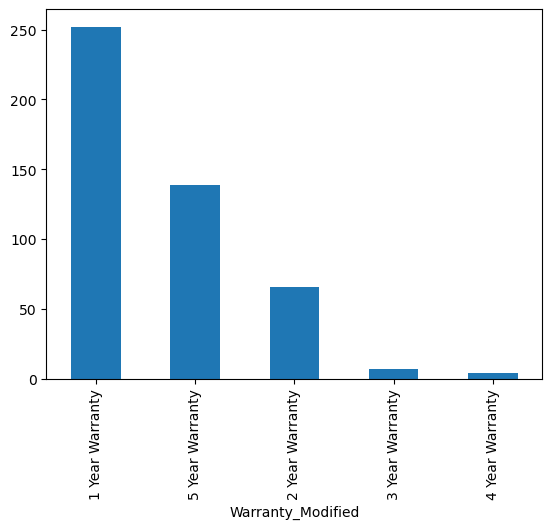

In [473]:
df["Warranty_Modified"].value_counts().nlargest(10).plot(kind="bar")

<Axes: ylabel='count'>

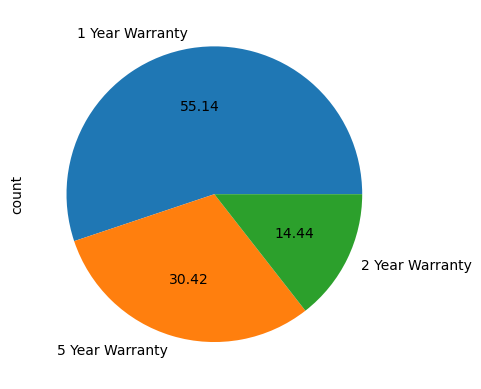

In [474]:
df["Warranty_Modified"].value_counts().nlargest(3).plot(kind="pie",autopct="%.2f")

<Axes: ylabel='Frequency'>

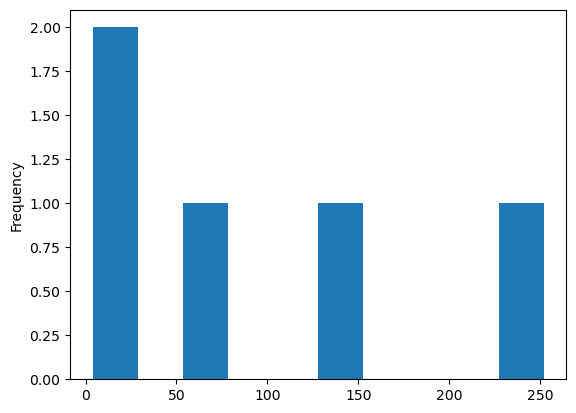

In [476]:
df["Warranty_Modified"].value_counts().plot(kind="hist")

# bivaraite analysis

In [480]:
df.columns

Index(['Brand', 'Model', 'DisplaySize', 'Resolution', 'Rating',
       'Original_Price', 'Sale_Price', 'Operating_system',
       'Warranty_Modified'],
      dtype='object')

### continuous-continuous

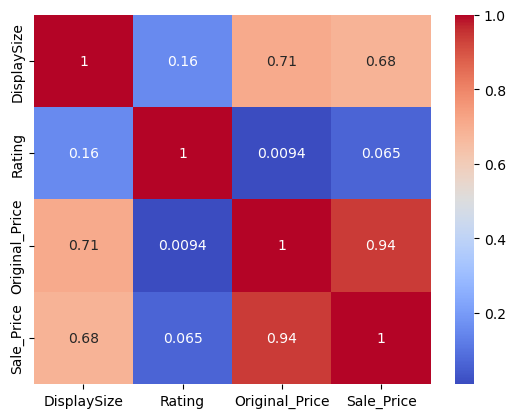

In [483]:
# Correlation matrix
correlation_matrix = df[['DisplaySize', 'Rating', 'Original_Price', 'Sale_Price']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.show()

-Using a correlation matrix or heatmap to explore relationships between continuous variables, like Sale_Price, Original_Price, DisplaySize, and Rating. This can help reveal any strong linear relationships.

### Categorical to Categorical Variables

In [488]:
#analyze how Operating_system varies by Brand or how many models offer each Resolution option.

In [490]:
brandsize5=df.groupby(['Brand','Operating_system'],as_index=False)['Sale_Price'].max().sort_values('Sale_Price',ascending=False)[:10]

In [492]:
brandsize5

,Brand,Operating_system,Sale_Price
17,Hisense,Android,379899.0
52,SAMSUNG,Tizen,305900.0
62,TCL,Google TV,249990.0
18,Hisense,Google TV,204990.0
37,MOTOROLA,Android,119999.0
16,Haier,Google TV,104900.0
31,LG,WebOS,89990.0
28,KODAK,Android,85199.0
65,Thomson,Android,79999.0
64,TOSHIBA,Google TV,79999.0


In [494]:
import seaborn as sns

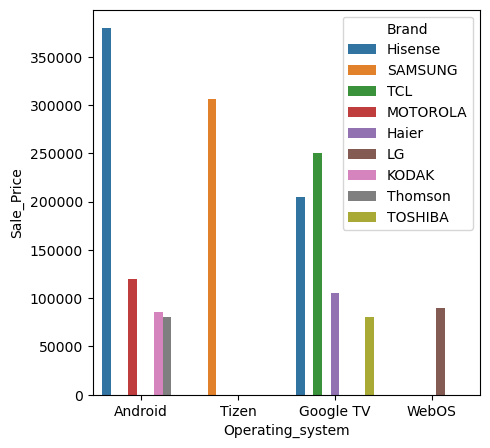

In [496]:
plt.figure(figsize=(5,5))
sns.barplot(data=brandsize5,x='Operating_system',y='Sale_Price',hue='Brand')
plt.show()

In [497]:
#Are TVs with higher ratings more expensive or do expensive TVs from well-known brands have higher ratings indicating premium quality?
round(df.groupby('Brand')['Rating'].mean().sort_values(ascending=False),1)

Brand
SONY           4.5
Blaupunkt      4.5
KODAK          4.4
LG             4.4
Admiral        4.4
CANDY          4.4
Thomson        4.4
Vu             4.3
realme         4.3
OnePlus        4.3
TOSHIBA        4.3
Hisense        4.3
Haier          4.3
Mi             4.3
SAMSUNG        4.3
MOTOROLA       4.3
SENS           4.2
Sansui         4.2
Coocaa         4.2
MarQ           4.2
iFFALCON       4.2
Panasonic      4.2
Daiwa          4.2
LIMEBERRY      4.2
VONE           4.2
LEEMA          4.2
IAIR           4.2
INAYA          4.2
REALMERCURY    4.2
Samtonic       4.2
acerpure       4.2
ONIDA          4.2
Acer           4.2
INVANTER       4.1
Infinix        4.1
BPL            4.1
REDMI          4.1
NU             4.1
XElectron      4.1
TCL            4.1
SKYTRON        4.0
Dyanora        4.0
IMPEX          4.0
Lloyd          3.9
Foxsky         3.9
InnoQ          3.9
Reliance       3.9
T              2.8
Name: Rating, dtype: float64

# 1. Brand Popularity & Price Range

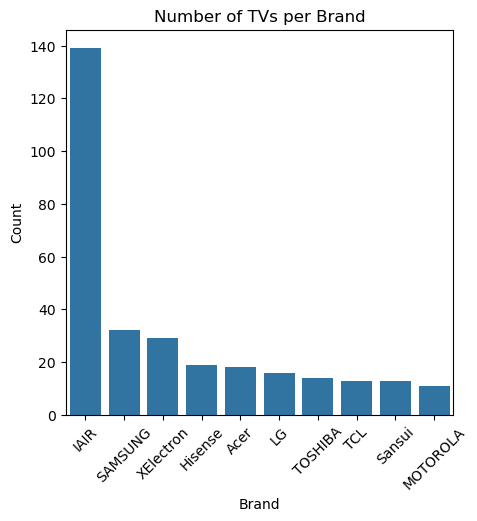

In [503]:
brand_counts = df['Brand'].value_counts()
top_10=brand_counts.head(10)
brand_avg_price = df.groupby('Brand')['Sale_Price'].mean().sort_values(ascending=False)

plt.figure(figsize=(5,5))
sns.barplot(x=top_10.index, y=top_10.values)
plt.title("Number of TVs per Brand")

plt.xlabel("Brand")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

# Plotting Price Range per Brand (Top 10 Brands)

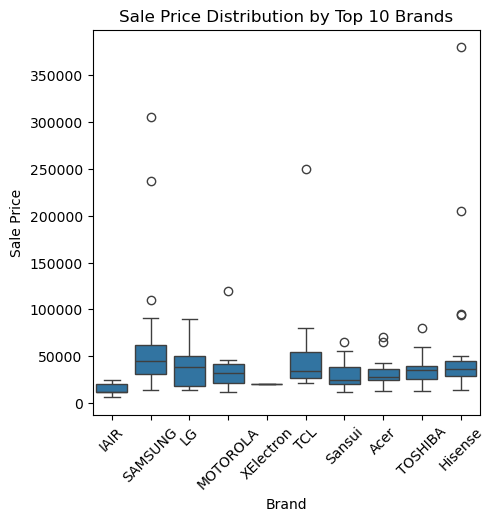

In [506]:
top_10 = brand_counts.head(10).index
filtered_df = df[df['Brand'].isin(top_10)]
plt.figure(figsize=(5,5))
sns.boxplot(x='Brand', y='Sale_Price', data=filtered_df)
plt.title("Sale Price Distribution by Top 10 Brands")
plt.xlabel("Brand")
plt.ylabel("Sale Price")
plt.xticks(rotation=45)
plt.show()

In [507]:
df["Brand"].value_counts()

Brand
IAIR           139
SAMSUNG         32
XElectron       29
Hisense         19
Acer            18
LG              16
TOSHIBA         14
TCL             13
Sansui          13
MOTOROLA        11
Thomson         11
Haier           11
Mi              10
Daiwa            8
Infinix          8
Blaupunkt        8
Lloyd            7
Coocaa           7
KODAK            7
SONY             6
Panasonic        6
iFFALCON         6
realme           6
Vu               5
CANDY            5
Foxsky           5
Admiral          4
INVANTER         4
acerpure         4
SENS             4
IMPEX            4
BPL              3
InnoQ            3
Reliance         3
ONIDA            3
NU               2
Samtonic         2
LIMEBERRY        2
Dyanora          1
OnePlus          1
REDMI            1
LEEMA            1
VONE             1
MarQ             1
T                1
REALMERCURY      1
INAYA            1
SKYTRON          1
Name: count, dtype: int64

In [508]:
df[df["Brand"]=="XElectron"]

,Brand,Model,DisplaySize,Resolution,Rating,Original_Price,Sale_Price,Operating_system,Warranty_Modified
6,XElectron,XElectron 10,43.0,Ultra HD,4.1,34999.0,19950.0,Android,1 Year Warranty
20,XElectron,XElectron 10,43.0,Ultra HD,4.1,34999.0,19950.0,Android,1 Year Warranty
36,XElectron,XElectron 10,43.0,Ultra HD,4.1,34999.0,19950.0,Android,1 Year Warranty
57,XElectron,XElectron 10,43.0,Ultra HD,4.1,34999.0,19950.0,Android,1 Year Warranty
72,XElectron,XElectron 10,43.0,Ultra HD,4.1,34999.0,19950.0,Android,1 Year Warranty
97,XElectron,XElectron 10,43.0,Ultra HD,4.1,34999.0,19950.0,Android,1 Year Warranty
111,XElectron,XElectron 10,43.0,Ultra HD,4.1,34999.0,19950.0,Android,1 Year Warranty
125,XElectron,XElectron 10,43.0,Ultra HD,4.1,34999.0,19950.0,Android,1 Year Warranty
145,XElectron,XElectron 10,43.0,Ultra HD,4.1,34999.0,19950.0,Android,1 Year Warranty
159,XElectron,XElectron 10,43.0,Ultra HD,4.1,34999.0,19950.0,Android,1 Year Warranty


In [512]:
df.duplicated().sum()

169

**1. Brand Popularity & Price Range** 
- Insights:
- The top 5/10 brands dominate the market in terms of product count.
- Premium brands (e.g., LG, Samsung) tend to have higher price ranges, while budget brands (e.g., IAIR, MI) focus on affordability.
- Price variation within a brand can highlight product differentiation strategies (e.g., basic vs. high-end models).

In [515]:
df.columns

Index(['Brand', 'Model', 'DisplaySize', 'Resolution', 'Rating',
       'Original_Price', 'Sale_Price', 'Operating_system',
       'Warranty_Modified'],
      dtype='object')

In [517]:
brand_resolution_avg_price = df.groupby(['Brand', 'Resolution'])['Sale_Price'].mean().reset_index()
brand_resolution_avg_price

,Brand,Resolution,Sale_Price
0,Acer,Full HD,20999.000000
1,Acer,HD Ready,15999.000000
2,Acer,QLED,29715.666667
3,Acer,Ultra HD,37051.300000
4,Admiral,Full HD,19999.000000
...,...,...,...
114,iFFALCON,Full HD,14999.000000
115,iFFALCON,Ultra HD,27299.000000
116,realme,Full HD,18099.000000
117,realme,QLED,31999.000000


In [519]:
brand_counts = df['Brand'].value_counts()
top_5_brands = brand_counts.head(5).index
filtered_df = brand_resolution_avg_price[brand_resolution_avg_price['Brand'].isin(top_5_brands)]
filtered_df

,Brand,Resolution,Sale_Price
0,Acer,Full HD,20999.000000
1,Acer,HD Ready,15999.000000
2,Acer,QLED,29715.666667
3,Acer,Ultra HD,37051.300000
31,Hisense,Full HD,19999.000000
32,Hisense,HD Ready,13890.000000
33,Hisense,QLED,108697.714286
34,Hisense,Ultra HD,46308.100000
35,IAIR,HD Ready,14761.669065
79,SAMSUNG,Full HD,26540.000000


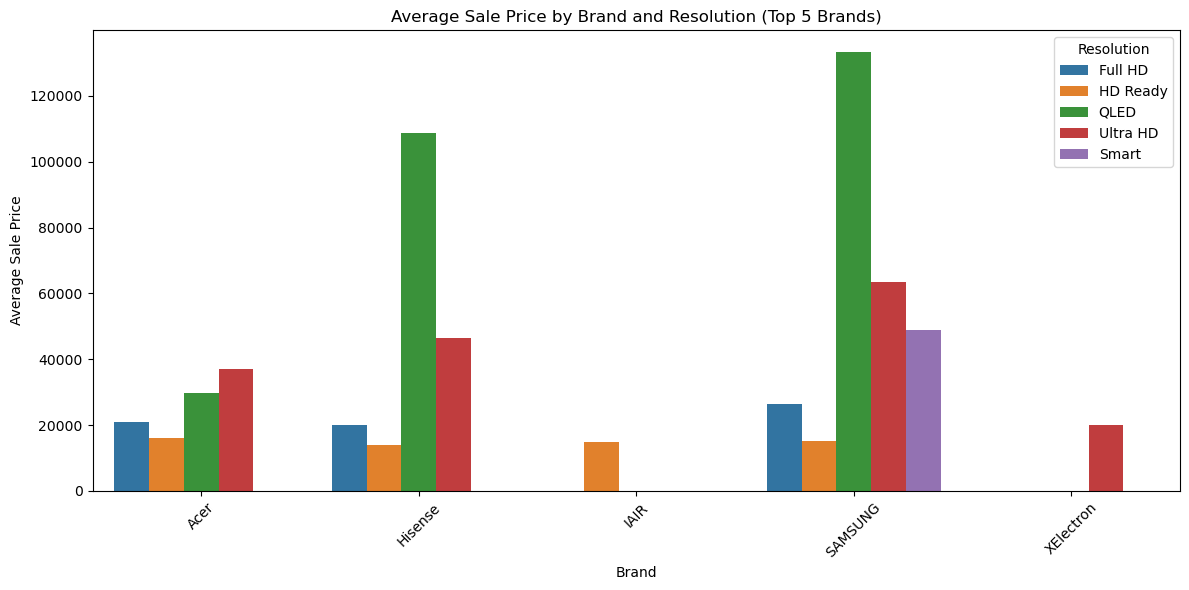

In [521]:
import seaborn as sns
import matplotlib.pyplot as plt


brand_resolution_avg_price = df.groupby(['Brand', 'Resolution'])['Sale_Price'].mean().reset_index()


brand_counts = df['Brand'].value_counts()
top_5_brands = brand_counts.head(5).index
filtered_df = brand_resolution_avg_price[brand_resolution_avg_price['Brand'].isin(top_5_brands)]

plt.figure(figsize=(12, 6))
sns.barplot(data=filtered_df, x='Brand', y='Sale_Price', hue='Resolution')

plt.title("Average Sale Price by Brand and Resolution (Top 5 Brands)")
plt.xlabel("Brand")
plt.ylabel("Average Sale Price")
plt.xticks(rotation=45)
plt.legend(title="Resolution")
plt.tight_layout()

# Show the plot
plt.show()


-Premium Resolutions Drive Higher Prices:
Samsung QLED ($285,945) and Hisense QLED ($128,147.50) are priced significantly higher than Full HD and HD Ready models, indicating that higher resolutions like QLED and Ultra HD are positioned as premium offerings targeting customers willing to invest in top-tier technology.

-Affordable Alternatives for Budget-Conscious Buyers:
Hisense and Samsung's HD Ready and Full HD models are priced more affordably, making them ideal choices for customers seeking quality without the premium price tag, with Hisense offering a competitive balance between price and advanced features like Ultra HD at a lower cost.

##### Premium resolutions like QLED and Ultra HD are much more expensive, with Samsung offering the highest prices, while Hisense provides more affordable options like Full HD and HD Ready that still offer good quality for customers on a budget.

# 2. Display Size vs Price and rating

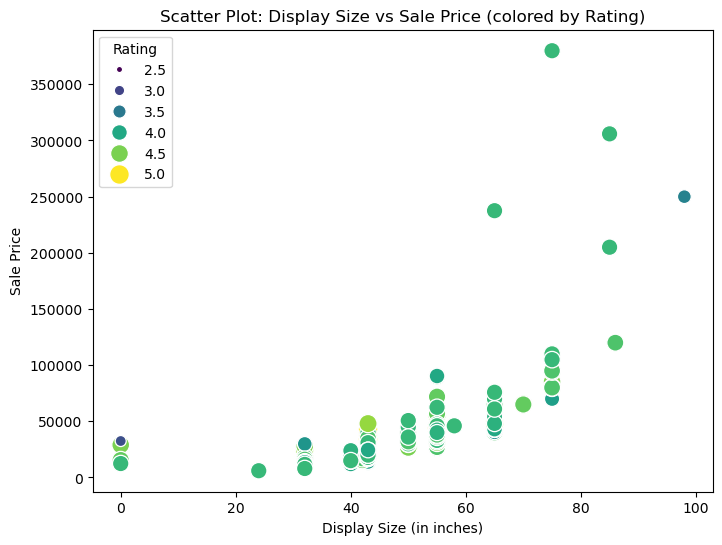

In [294]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='DisplaySize', y='Sale_Price', hue='Rating', size='Rating',palette="viridis", sizes=(20, 200))
plt.title("Scatter Plot: Display Size vs Sale Price (colored by Rating)")
plt.xlabel("Display Size (in inches)")
plt.ylabel("Sale Price")
plt.legend(title='Rating', loc='upper left')
plt.show()

As display size increases, prices rise, with mid-sized displays (40–60 inches) offering the best balance of affordability and customer satisfaction. Smaller displays are cheaper but have lower ratings, while larger displays vary in price due to premium features
l.

# display size and sale price

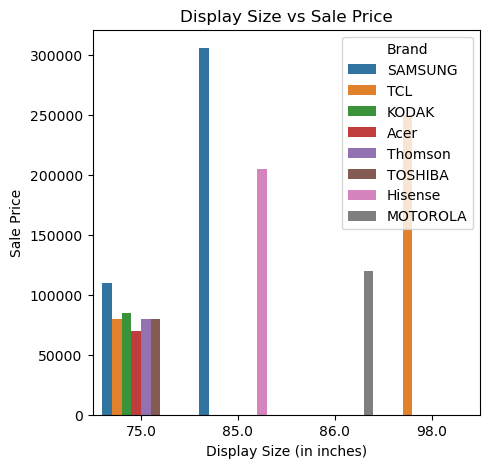

In [303]:
top_10 = df.nlargest(10,'DisplaySize')
plt.figure(figsize=(5,5))
sns.barplot(x='DisplaySize', y='Sale_Price', data=top_10, hue='Brand')
plt.title("Display Size vs Sale Price")
plt.xlabel("Display Size (in inches)")
plt.ylabel("Sale Price")
plt.show()

**Insights:**
- Larger display sizes typically correspond to higher prices, indicating a positive correlation between size and cost.
- However, some budget-friendly brands offer larger screens at lower prices, possibly as a competitive strategy.


# 3. Resolution & Price

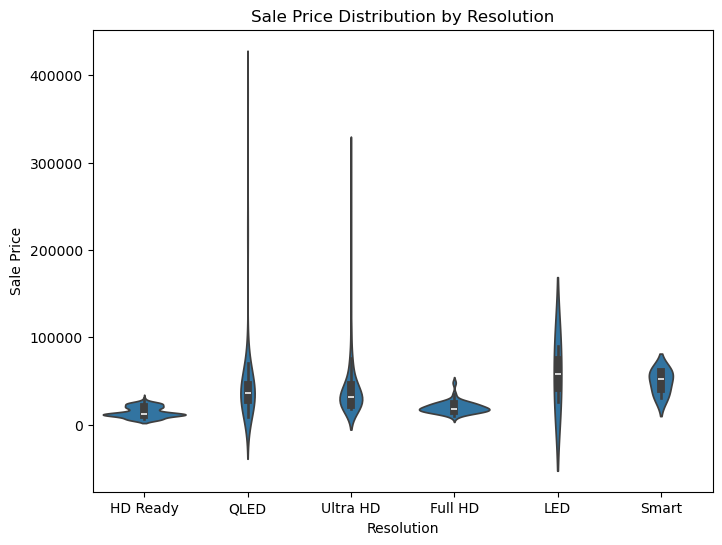

In [307]:
import seaborn as sns
import matplotlib.pyplot as plt

# Basic Violin Plot
plt.figure(figsize=(8, 6))
sns.violinplot(x='Resolution', y='Sale_Price', data=df)
plt.title("Sale Price Distribution by Resolution")
plt.xlabel("Resolution")
plt.ylabel("Sale Price")
plt.show()


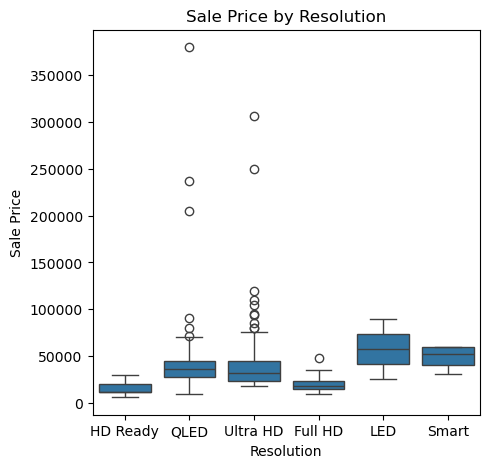

In [308]:
plt.figure(figsize=(5,5))
sns.boxplot(x='Resolution', y='Sale_Price', data=df)
plt.title("Sale Price by Resolution")
plt.xlabel("Resolution")
plt.ylabel("Sale Price")
plt.show()

- Lowest: HD Ready(720p)
- Moderate: Full HD(1080p)
- Higher: Ultra HD (4K)
- Not resolution-based: QLED(Usually available in 4K or higher resolutions), LED(It can support HD, Full HD, or 4K), Smart(Refers to functionality (internet-enabled TVs)


**Insights:**
- TVs with higher resolutions command a premium price.
- Brands offering cutting-edge resolution technology (e.g.,QLED) are priced significantly higher, targeting premium customers.

# 4. Rating vs Price

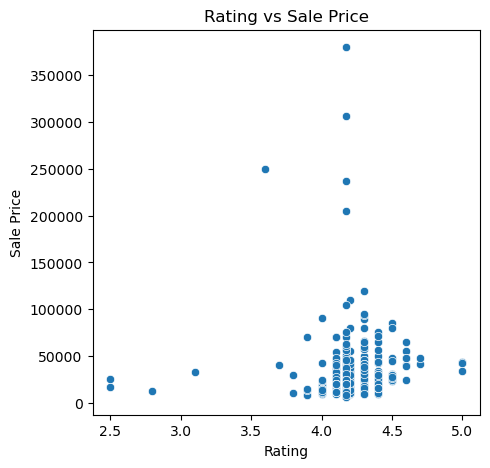

In [314]:
plt.figure(figsize=(5,5))
sns.scatterplot(x='Rating', y='Sale_Price', data=df)
plt.title("Rating vs Sale Price")
plt.xlabel("Rating")
plt.ylabel("Sale Price")
plt.show()

**Insights:**
- Higher-rated TVs often have mid-to-high price ranges, suggesting that customers appreciate quality for value.
- Some low-rated TVs in the higher price segment may indicate dissatisfaction with the value-for-money proposition or performance issues.
- Budget TVs with decent ratings are appealing to cost-conscious buyers.

# 5. Price Drop Analysis

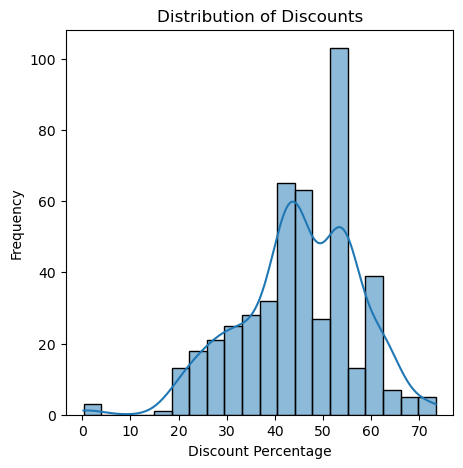

In [318]:
df['Discount_Percentage'] = ((df['Original_Price'] - df['Sale_Price']) / df['Original_Price']) * 100
plt.figure(figsize=(5,5))
sns.histplot(df['Discount_Percentage'], bins=20, kde=True)
plt.title("Distribution of Discounts")
plt.xlabel("Discount Percentage")
plt.ylabel("Frequency")
plt.show()

**Insights:**
- Significant discounts (20%-50%) are common, especially during sales, on mid-range and budget TVs.


# 6. Operating System Analysis

Text(0, 0.5, 'Sale Price')

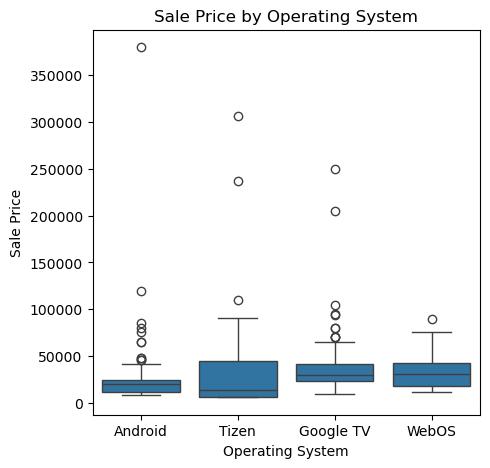

In [322]:
plt.figure(figsize=(5,5))
sns.boxplot(x='Operating_system', y='Sale_Price', data=df)
plt.title("Sale Price by Operating System")
plt.xlabel("Operating System")
plt.ylabel("Sale Price")

# 7. Warranty Impact

C:\Users\yetti\AppData\Local\Temp\ipykernel_20264\1993542466.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Warranty_Modified', y='Sale_Price', data=df, palette='Blues_d')


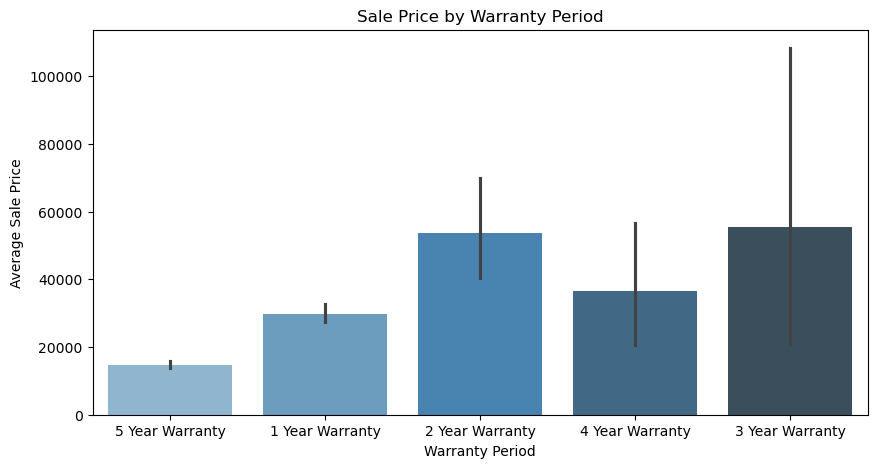

In [325]:
plt.figure(figsize=(10,5))
sns.barplot(x='Warranty_Modified', y='Sale_Price', data=df, palette='Blues_d')
plt.title("Sale Price by Warranty Period")
plt.xlabel("Warranty Period")
plt.ylabel("Average Sale Price")
plt.show()

**Insights:**
- TVs with extended warranties are priced higher, likely due to the perceived reliability or premium positioning.
- Budget brands typically offer shorter warranties, while premium brands use extended warranties as a trust-building measure.

In [328]:
df.columns

Index(['Brand', 'Model', 'DisplaySize', 'Resolution', 'Rating',
       'Original_Price', 'Sale_Price', 'Operating_system', 'Warranty_Modified',
       'Discount_Percentage'],
      dtype='object')

C:\Users\yetti\AppData\Local\Temp\ipykernel_20264\2357387006.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


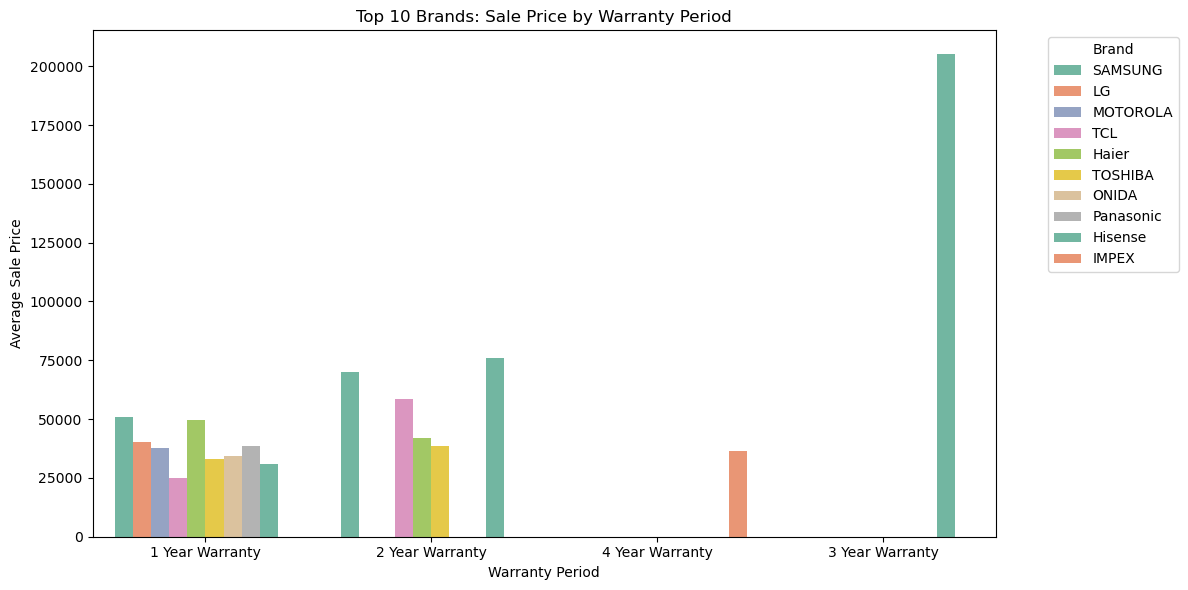

In [545]:


# Calculate the top 10 brands by average sale price
top_brands = (
    df.groupby('Brand')['Sale_Price']
    .mean()
    .nlargest(10)  # Select the 10 largest average sale prices
    .index  # Get the brand names
)

# Filter the DataFrame for the top 10 brands
df_top_brands = df[df['Brand'].isin(top_brands)]

# Plot the data for only the top 10 brands
plt.figure(figsize=(12, 6))
sns.barplot(
    x='Warranty_Modified',
    y='Sale_Price',
    hue='Brand',
    data=df_top_brands,  # Use the filtered DataFrame
    palette='Set2',
    ci=None  # Disable error bars for simplicity (optional)
)
plt.title("Top 10 Brands: Sale Price by Warranty Period")
plt.xlabel("Warranty Period")
plt.ylabel("Average Sale Price")
plt.legend(title='Brand', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position
plt.tight_layout()  # Adjust layout for better spacing
plt.show()
